In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

print('Finished imports...')

Finished imports...


In [2]:
train_client=pd.read_csv('client_train.csv')
test_client=pd.read_csv('client_test.csv')
train_invoice=pd.read_csv('invoice_train.csv')
test_invoice=pd.read_csv('invoice_test.csv')
print('Finished data read...')

Finished data read...


In [3]:
train_client.head(10)

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0
5,69,train_Client_10000,11,103,29/09/1993,0.0
6,62,train_Client_100000,11,309,07/06/2012,0.0
7,60,train_Client_100001,11,101,12/04/2006,0.0
8,62,train_Client_100002,11,301,31/12/2006,0.0
9,60,train_Client_100003,11,101,25/10/2011,0.0


In [4]:
train_invoice.head(10)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
5,train_Client_0,2017-07-17,11,1335667,0,207,9,1,314,0,0,0,15638,15952,8,ELEC
6,train_Client_0,2018-12-07,11,1335667,0,207,9,1,541,0,0,0,15952,16493,12,ELEC
7,train_Client_0,2019-03-19,11,1335667,0,207,9,1,585,0,0,0,16493,17078,8,ELEC
8,train_Client_0,2011-07-22,11,1335667,0,203,9,1,1200,186,0,0,7770,9156,4,ELEC
9,train_Client_0,2011-11-22,11,1335667,0,203,6,1,1082,0,0,0,9156,10238,4,ELEC


In [5]:
d={"ELEC":0,"GAZ":1}
train_invoice['counter_type']=train_invoice['counter_type'].map(d)

In [6]:
train_client['client_catg'] = train_client['client_catg'].astype('object')
train_client['disrict'] = train_client['disrict'].astype('object')

test_client['client_catg'] = test_client['client_catg'].astype('object')
test_client['disrict'] = test_client['disrict'].astype('object')

In [7]:
train_invoice['counter_type'].value_counts()

counter_type
0    3079406
1    1397343
Name: count, dtype: int64

In [8]:
for df in [train_invoice,test_invoice]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    df['year'] = df['invoice_date'].dt.year
    df['month'] = df['invoice_date'].dt.month


In [9]:
aggs = {}
aggs['consommation_level_1'] = ['sum','max','min','mean','std']
aggs['consommation_level_2'] = ['sum','max','min','mean','std']
aggs['consommation_level_3'] = ['sum','max','min','mean','std']
aggs['consommation_level_4'] = ['sum','max','min','mean','std']

aggs['month'] = ['mean', 'max', 'min', 'std']
aggs['year'] = ['nunique','max','min','mean']

aggs['months_number'] = ['max','min','mean','sum']
aggs['reading_remarque'] = ['max','min','mean','std','sum']
aggs['counter_coefficient'] = ['max', 'min','mean']
aggs['counter_number'] = ['nunique']
aggs['counter_type'] = ['nunique','mean','sum']
aggs['counter_statue'] = ['nunique']
aggs['tarif_type'] = ['nunique','max','min']
aggs['counter_code'] = ['nunique','max','mean','min']


aggs['old_index'] = ['nunique','mean','std']
aggs['old_index'] = ['nunique','mean','std']

In [10]:
    agg_trans = train_invoice.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (train_invoice.groupby('client_id')
          .size()
          .reset_index(name='{}transactions_count'.format('1')))

    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')

In [11]:
agg_trans.head()

,client_id,1transactions_count,consommation_level_1_sum,consommation_level_1_max,consommation_level_1_min,consommation_level_1_mean,consommation_level_1_std,consommation_level_2_sum,consommation_level_2_max,consommation_level_2_min,...,tarif_type_nunique,tarif_type_max,tarif_type_min,counter_code_nunique,counter_code_max,counter_code_mean,counter_code_min,old_index_nunique,old_index_mean,old_index_std
0,train_Client_0,35,12334,1200,38,352.400000,310.343472,370,186,0,...,1,11,11,2,207,203.685714,203,35,9444.542857,4527.744415
1,train_Client_1,37,20629,1207,190,557.540541,197.935960,0,0,0,...,1,11,11,1,203,203.000000,203,37,14330.756757,6124.126094
2,train_Client_10,18,14375,2400,188,798.611111,513.841374,682,682,0,...,1,11,11,2,207,203.222222,203,18,32873.000000,5317.180865
3,train_Client_100,20,24,15,0,1.200000,3.607011,0,0,0,...,1,11,11,1,413,413.000000,413,4,94.150000,4.120232
4,train_Client_1000,14,9292,800,124,663.714286,224.831365,1468,400,0,...,1,11,11,1,207,207.000000,207,14,6900.428571,4732.111217


In [12]:
train = pd.merge(train_client,agg_trans, on='client_id', how='left')

In [13]:
test_client.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [14]:
test_invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC,2018,3
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC,2014,3
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC,2014,7
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC,2015,7
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC,2016,7


In [15]:
d={"ELEC":0,"GAZ":1}
test_invoice['counter_type']=test_invoice['counter_type'].map(d)

In [16]:
    agg_trans = test_invoice.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (test_invoice.groupby('client_id')
          .size()
          .reset_index(name='{}transactions_count'.format('1')))

    agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')

In [17]:
test = pd.merge(test_client,agg_trans, on='client_id', how='left')

In [18]:
train.head(10)

,disrict,client_id,client_catg,region,creation_date,target,1transactions_count,consommation_level_1_sum,consommation_level_1_max,consommation_level_1_min,...,tarif_type_nunique,tarif_type_max,tarif_type_min,counter_code_nunique,counter_code_max,counter_code_mean,counter_code_min,old_index_nunique,old_index_mean,old_index_std
0,60,train_Client_0,11,101,31/12/1994,0.0,35,12334,1200,38,...,1,11,11,2,207,203.685714,203,35,9444.542857,4527.744415
1,69,train_Client_1,11,107,29/05/2002,0.0,37,20629,1207,190,...,1,11,11,1,203,203.000000,203,37,14330.756757,6124.126094
2,62,train_Client_10,11,301,13/03/1986,0.0,18,14375,2400,188,...,1,11,11,2,207,203.222222,203,18,32873.000000,5317.180865
3,69,train_Client_100,11,105,11/07/1996,0.0,20,24,15,0,...,1,11,11,1,413,413.000000,413,4,94.150000,4.120232
4,62,train_Client_1000,11,303,14/10/2014,0.0,14,9292,800,124,...,1,11,11,1,207,207.000000,207,14,6900.428571,4732.111217
5,69,train_Client_10000,11,103,29/09/1993,0.0,48,16901,1414,0,...,2,40,11,2,203,124.625000,5,45,13789.625000,10536.192177
6,62,train_Client_100000,11,309,07/06/2012,0.0,40,11201,1200,0,...,2,40,11,2,413,209.000000,5,37,19788.750000,16818.314522
7,60,train_Client_100001,11,101,12/04/2006,0.0,78,25545,1101,0,...,2,40,11,2,203,106.538462,5,71,6583.141026,6652.875339
8,62,train_Client_100002,11,301,31/12/2006,0.0,2,225,218,7,...,1,11,11,1,413,413.000000,413,2,3.500000,4.949747
9,60,train_Client_100003,11,101,25/10/2011,0.0,5,4254,1200,254,...,1,11,11,1,467,467.000000,467,5,9342.200000,12838.345812


In [19]:
test.head(10)

,disrict,client_id,client_catg,region,creation_date,1transactions_count,consommation_level_1_sum,consommation_level_1_max,consommation_level_1_min,consommation_level_1_mean,...,tarif_type_nunique,tarif_type_max,tarif_type_min,counter_code_nunique,counter_code_max,counter_code_mean,counter_code_min,old_index_nunique,old_index_mean,old_index_std
0,62,test_Client_0,11,307,28/05/2002,37,18061,1090,0,488.135135,...,1,11,11,1,203,203.000000,203,36,11389.837838,5401.043096
1,69,test_Client_1,11,103,06/08/2009,22,24011,3600,11,1091.409091,...,1,11,11,1,433,433.000000,433,22,29380.772727,17638.422718
2,62,test_Client_10,11,310,07/04/2004,74,40999,1200,0,554.040541,...,2,40,11,2,207,119.648649,5,74,11774.054054,10987.377541
3,60,test_Client_100,11,101,08/10/1992,40,9774,721,0,244.350000,...,2,40,11,2,203,104.000000,5,39,13623.725000,13242.361986
4,62,test_Client_1000,11,301,21/07/1977,53,30114,2400,0,568.188679,...,2,40,11,2,203,135.754717,5,52,13927.471698,14371.199312
5,62,test_Client_10000,11,304,18/02/2015,12,7121,962,159,593.416667,...,1,11,11,1,420,420.000000,420,12,22582.583333,12430.670131
6,62,test_Client_10001,11,303,13/09/2005,77,791,281,0,10.272727,...,2,40,11,2,203,105.285714,5,18,130.129870,123.719691
7,69,test_Client_10002,11,104,10/02/2011,77,58274,3805,0,756.805195,...,3,45,11,3,420,209.415584,5,76,30106.129870,16807.909793
8,62,test_Client_10003,11,309,12/04/2013,19,12374,800,329,651.263158,...,1,11,11,1,207,207.000000,207,19,5941.315789,4553.366301
9,69,test_Client_10004,11,107,12/07/1993,62,35290,2400,0,569.193548,...,2,40,11,2,413,261.645161,5,56,22820.500000,18398.577260


In [20]:
train.shape,test.shape

((135493, 62), (58069, 61))

In [21]:
for df in [train,test]:
    df['creation_date'] = pd.to_datetime(df['creation_date'])
    df['year'] = df['creation_date'].dt.year
    df['month'] = df['creation_date'].dt.month
    df['month_diff'] = ((datetime.today() - df['creation_date']).dt.days)//30

In [22]:
col_to_drop = ['client_id', 
            'creation_date',
            'old_index_std',
            'reading_remarque_std',
            'month_std','consommation_level_1_std', 
            'consommation_level_2_std', 
            'consommation_level_3_std',
            'consommation_level_4_std']
for col in col_to_drop:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

In [23]:
from sklearn import preprocessing
for f in test.columns:
    if train[f].dtype=='object' or test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))  

In [24]:
all_data_na = train.isnull().sum() 
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing ' :all_data_na})
missing_data.head(10)

,Missing


In [25]:
target=train['target']
train.drop('target',axis=1,inplace=True)

Train invoices:  (4476749, 16)
Train clients:  (135493, 6) 

Test invoices:  (1939730, 16)
Test clients:  (58069, 5)
Number of missing rows in Train invoices: 0
Number of missing rows in Test invoices: 0 

Number of missing rows in Train clients: 0
Number of missing rows in Test clients: 0
Number of unique values in invoice_train:
client_id            <=========>                135493
invoice_date            <=========>                8275
tarif_type            <=========>                17
counter_number            <=========>                201893
counter_statue            <=========>                12
counter_code            <=========>                42
reading_remarque            <=========>                8
counter_coefficient            <=========>                16
consommation_level_1            <=========>                8295
consommation_level_2            <=========>                12576
consommation_level_3            <=========>                2253
consommation_level_4   

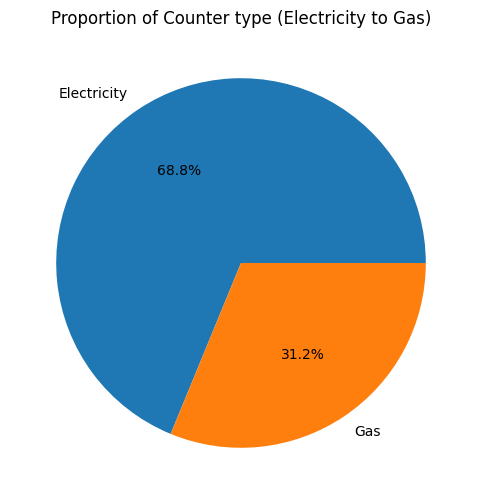

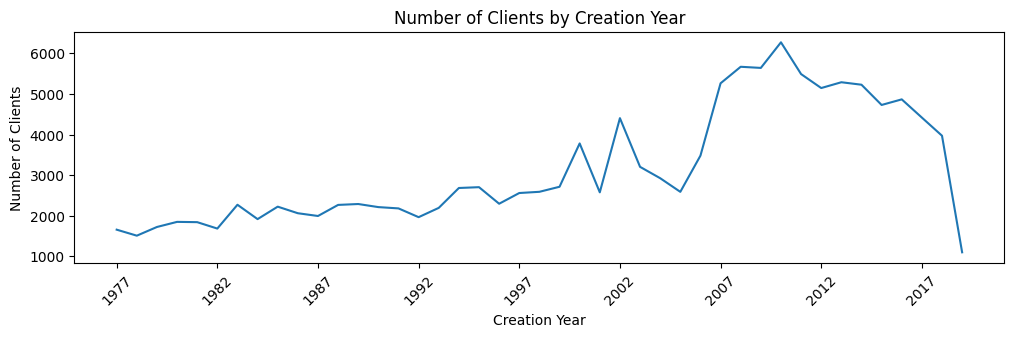

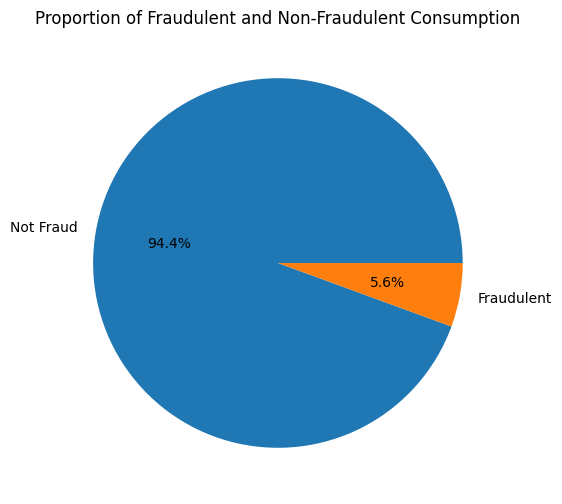

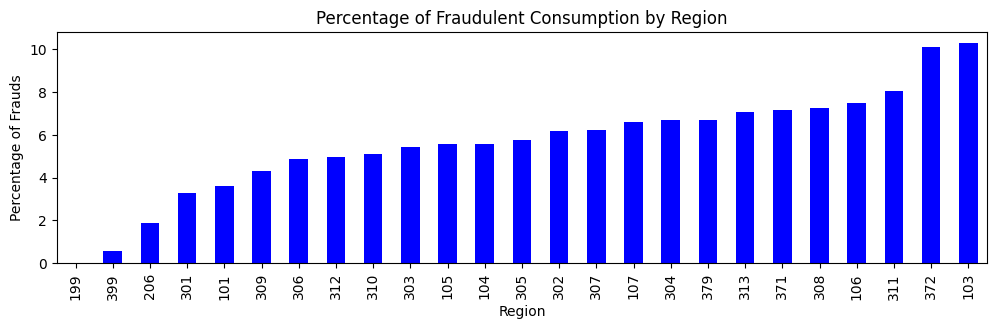

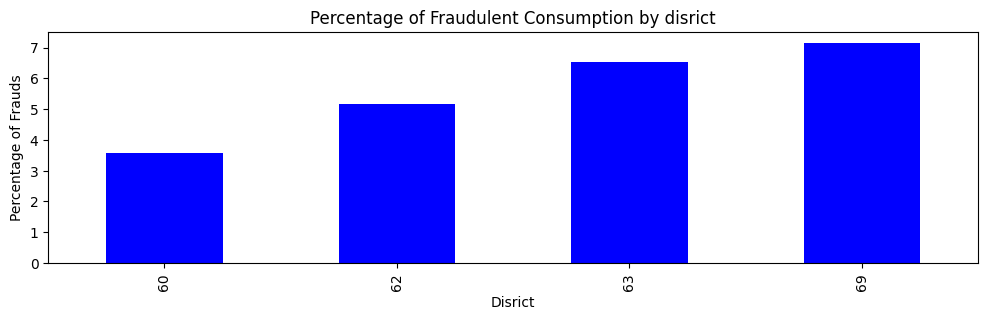

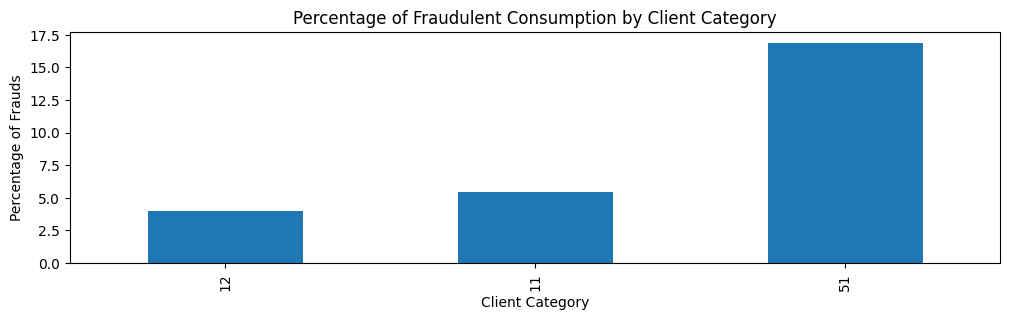

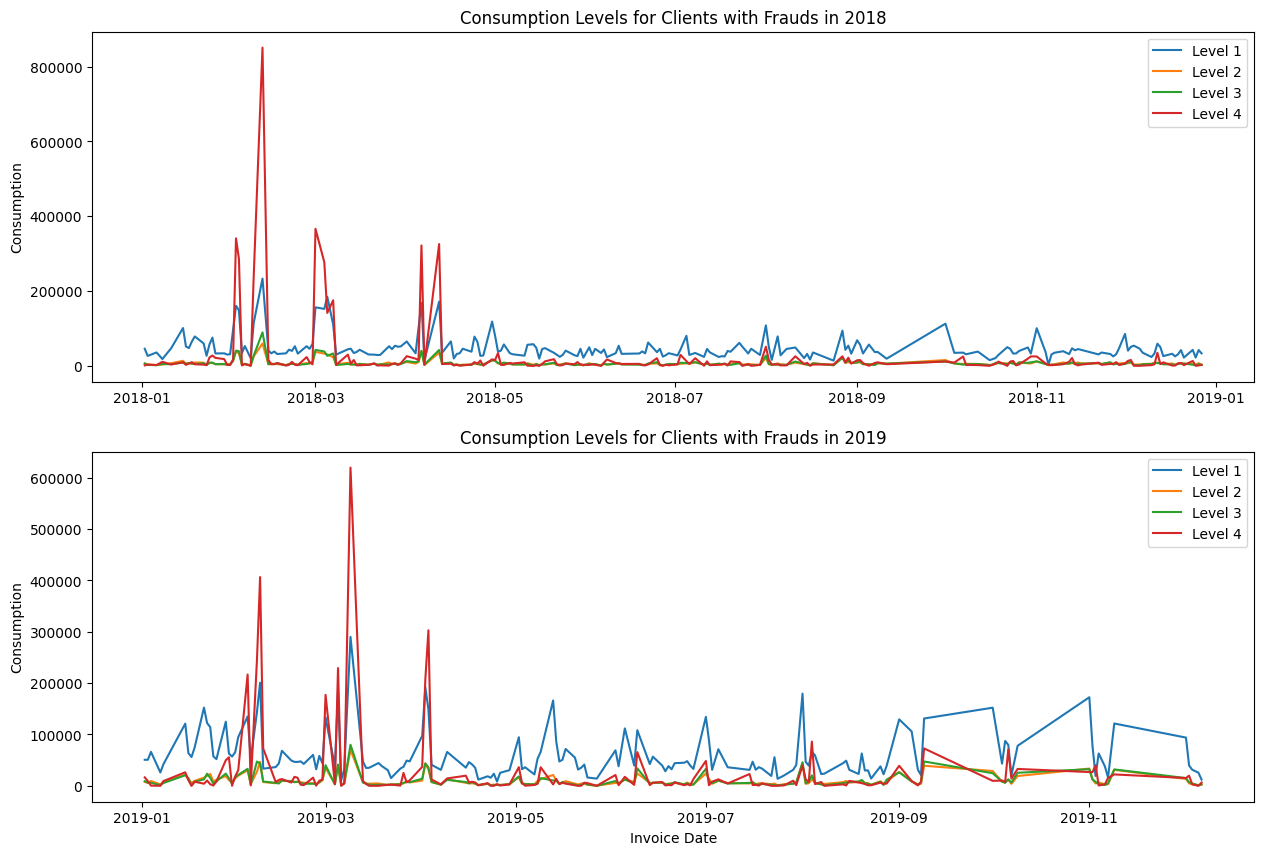

0:	learn: 0.6195903	total: 279ms	remaining: 4m 10s
50:	learn: 0.1615901	total: 6.76s	remaining: 1m 52s
100:	learn: 0.1510688	total: 13.4s	remaining: 1m 46s
150:	learn: 0.1454646	total: 19.8s	remaining: 1m 38s
200:	learn: 0.1409745	total: 26.3s	remaining: 1m 31s
250:	learn: 0.1370311	total: 33.1s	remaining: 1m 25s
300:	learn: 0.1331106	total: 39.5s	remaining: 1m 18s
350:	learn: 0.1294052	total: 45.9s	remaining: 1m 11s
400:	learn: 0.1263607	total: 50.9s	remaining: 1m 3s
450:	learn: 0.1236314	total: 58.2s	remaining: 57.9s
500:	learn: 0.1207715	total: 1m 5s	remaining: 52.1s
550:	learn: 0.1182529	total: 1m 12s	remaining: 46s
600:	learn: 0.1158623	total: 1m 33s	remaining: 46.8s
650:	learn: 0.1133882	total: 1m 42s	remaining: 39.3s
700:	learn: 0.1111198	total: 1m 56s	remaining: 33.1s
750:	learn: 0.1085877	total: 2m 19s	remaining: 27.6s
800:	learn: 0.1064268	total: 2m 27s	remaining: 18.3s
850:	learn: 0.1041221	total: 2m 36s	remaining: 9.02s
899:	learn: 0.1021329	total: 2m 43s	remaining: 0us
0:	

In [26]:
from sklearn.model_selection import KFold
from CatBoost import CatBoostClassifier
from sklearn.metrics import roc_auc_score


# invoiceYears = train_invoice['invoice_date'].dt.year.unique()


# Define KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store predictions and errors
predictions = []
# errors = []
auc_scores = []

# Iterate over folds
for fold, (train_idx, valid_idx) in enumerate(kf.split(train)):
    # Extract training and validation data for this fold
    X_train_fold, X_valid_fold = train.iloc[train_idx], train.iloc[valid_idx]
    y_train_fold, y_valid_fold = target[train_idx], target[valid_idx]

    # Define and train your model
    model = CatBoostClassifier(
        iterations=900,
        depth=8,
        learning_rate=0.055,
        subsample=0.9,
        colsample_bylevel=0.9,
        random_seed=42,
        verbose=50  # Set to 'Verbose' for training logs
    )

    # Train the model
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation set
    fold_preds = model.predict(X_valid_fold)
    
    '''# Evaluate model and store predictions and errors
    rmse = np.sqrt(mean_squared_error(y_valid_fold, fold_preds))
    errors.append(rmse)
    predictions.append(fold_preds)'''
    
    
    # Calculate AUC score for the fold
    auc = roc_auc_score(y_valid_fold, fold_preds)
    auc_scores.append(auc)

    # Optionally, you can also make predictions on the test set for each fold and save them for ensembling later

# Calculate average error across folds
# mean_error = np.mean(errors)
# print("Mean RMSE:", mean_error)

# Optionally, you can also ensemble the predictions from different folds here

# After ensembling (if applicable), you can make predictions on the test set using the ensemble model
# And write the submission file
# Calculate average AUC score across folds


mean_auc = np.mean(auc_scores)
print("Mean AUC:", mean_auc)

In [27]:
# Store predictions from this fold
fold_preds.append(fold_preds)

# Concatenate predictions from all folds into a single DataFrame
fold_preds_df = pd.DataFrame(np.concatenate(all_fold_preds))

# Assuming fold_preds_df contains the correct predictions
# Now you can proceed with creating the submission DataFrame
submission = pd.DataFrame({
    "client_id": sub["client_id"],
    "target": fold_preds_df[0]  # Assuming the predictions are in the first column
})

# Write the submission file
submission.to_csv('submission_fraud_cat_KFold.csv', index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
from catboost import CatBoostClassifier

# Create CatBoostClassifier instance
model= CatBoostClassifier(
    iterations=900,
    depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bylevel=0.9,
    random_seed=42,
    verbose=50  # Set to 'Verbose' for training logs
)

# Train the model
%time model.fit(train, target)

# After training, you can make predictions
predictions = model.predict_proba(test)

# Calculate the AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc)


0:	learn: 0.6228451	total: 100ms	remaining: 50s
50:	learn: 0.1652085	total: 5.01s	remaining: 44.1s
100:	learn: 0.1531686	total: 10.1s	remaining: 39.7s
150:	learn: 0.1477308	total: 15.5s	remaining: 35.7s
200:	learn: 0.1437199	total: 20.5s	remaining: 30.6s
250:	learn: 0.1401112	total: 25.6s	remaining: 25.4s
300:	learn: 0.1366255	total: 30.4s	remaining: 20.1s
350:	learn: 0.1335095	total: 35.7s	remaining: 15.1s
400:	learn: 0.1307856	total: 41s	remaining: 10.1s
450:	learn: 0.1280829	total: 46.2s	remaining: 5.02s
499:	learn: 0.1256822	total: 50.7s	remaining: 0us
CPU times: total: 4min 8s
Wall time: 56 s


In [ ]:












submission = pd.DataFrame({
        "client_id": sub["client_id"],
        "target": preds[1]
    })
submission.to_csv('submission_fraud_cat.csv', index=False)

In [ ]:
import xgboost as xgb

# Create XGBoost Classifier instance
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.055,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    verbosity=1  # Set to 1 for training logs
)

# Train the model
%time model.fit(train, target)

# After training, you can make predictions
predictions = model.predict(test)

print


CPU times: total: 4min 48s
Wall time: 1min


In [ ]:
pred=model.predict_proba(test)

In [ ]:
preds = (pred) 

In [ ]:
preds = pd.DataFrame(preds)

In [ ]:
preds.head(10)

,0,1
0,0.979904,0.020096
1,0.974732,0.025268
2,0.997406,0.002594
3,0.997638,0.002362
4,0.974954,0.025046
5,0.984502,0.015498
6,0.999922,0.000079
7,0.669456,0.330544
8,0.999212,0.000788
9,0.982634,0.017366


In [ ]:
sub=pd.read_csv('SampleSubmission (4).csv')

In [ ]:
submission = pd.DataFrame({
        "client_id": sub["client_id"],
        "target": preds[1]
    })
submission.to_csv('submission_fraud_new.csv', index=False)

In [ ]:
submission.head(10)

,client_id,target
0,test_Client_0,0.020096
1,test_Client_1,0.025268
2,test_Client_10,0.002594
3,test_Client_100,0.002362
4,test_Client_1000,0.025046
5,test_Client_10000,0.015498
6,test_Client_10001,0.000079
7,test_Client_10002,0.330544
8,test_Client_10003,0.000788
9,test_Client_10004,0.017366
